# Plot posterior predictive checks for natural H3N2 populations

In [1]:
import arviz as az
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.stats import gamma
import seaborn as sns

In [2]:
rng = default_rng(314159)

Load original data used to fit a model.

In [3]:
distances = pd.read_csv("../results/model_inputs_for_h3n2_populations.tsv", sep="\t")

In [4]:
distances.head()

,horizon,future_timepoint,distance,initial_timepoint,delay,t,future_timepoint_numeric
0,3,2011-07-01,2.091841,2011-04-01,0.0,1,2011.50
1,3,2011-10-01,6.180108,2011-07-01,0.0,2,2011.75
2,3,2012-01-01,2.741423,2011-10-01,0.0,3,2012.00
3,3,2012-04-01,2.570344,2012-01-01,0.0,4,2012.25
4,3,2012-07-01,2.703375,2012-04-01,0.0,5,2012.50


In [5]:
delay_mean = distances["delay"].mean()
delay_sd = distances["delay"].std()

In [6]:
distances["delay_s"] = (distances["delay"] - delay_mean) / delay_sd

In [7]:
horizon_mean = distances["horizon"].mean()
horizon_sd = distances["horizon"].std()

In [8]:
distances["horizon_s"] = (distances["horizon"] - horizon_mean) / horizon_sd

In [9]:
distances.head()

,horizon,future_timepoint,distance,initial_timepoint,delay,t,future_timepoint_numeric,delay_s,horizon_s
0,3,2011-07-01,2.091841,2011-04-01,0.0,1,2011.50,-1.067674,-1.306336
1,3,2011-10-01,6.180108,2011-07-01,0.0,2,2011.75,-1.067674,-1.306336
2,3,2012-01-01,2.741423,2011-10-01,0.0,3,2012.00,-1.067674,-1.306336
3,3,2012-04-01,2.570344,2012-01-01,0.0,4,2012.25,-1.067674,-1.306336
4,3,2012-07-01,2.703375,2012-04-01,0.0,5,2012.50,-1.067674,-1.306336


Load posterior samples exported from rethinking/Stan analysis in R.

In [10]:
posterior = pd.read_csv("../results/h3n2_posterior.csv")

In [11]:
posterior.head()

,a,b_s,b_h,scale
0,1.41400,0.025906,0.232625,0.664325
1,1.46210,0.018360,0.218781,0.705282
2,1.42261,0.033095,0.232670,0.693499
3,1.42816,0.012502,0.285541,0.590681
4,1.42685,0.031298,0.226551,0.744201


## Plot distance to the present represented by intercept term

Calculate distance to the present without delays by setting delay=0 and horizon=0.

In [12]:
mu = np.exp(posterior["a"] + posterior["b_s"] * ((0 - delay_mean) / delay_sd) + posterior["b_h"] * ((0 - horizon_mean) / horizon_sd))

In [13]:
mu.head()

0    2.397753
1    2.614694
2    2.399758
3    2.195875
4    2.447308
dtype: float64

In [14]:
scale = posterior["scale"]

In [15]:
average_distance_to_present = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)

In [16]:
average_distance_to_present.shape

(10000,)

In [17]:
bins = np.arange(average_distance_to_present.min(), average_distance_to_present.max() + 0.1, 0.25)

In [18]:
mean_average_distance_to_present = average_distance_to_present.mean()

In [19]:
mean_average_distance_to_present

2.356337247174394

In [20]:
lower_hpdi_average_distance_to_present, upper_hpdi_average_distance_to_present = az.hdi(average_distance_to_present, 0.89)

In [21]:
lower_hpdi_average_distance_to_present

0.47530881605944564

In [22]:
upper_hpdi_average_distance_to_present

4.082524223761143

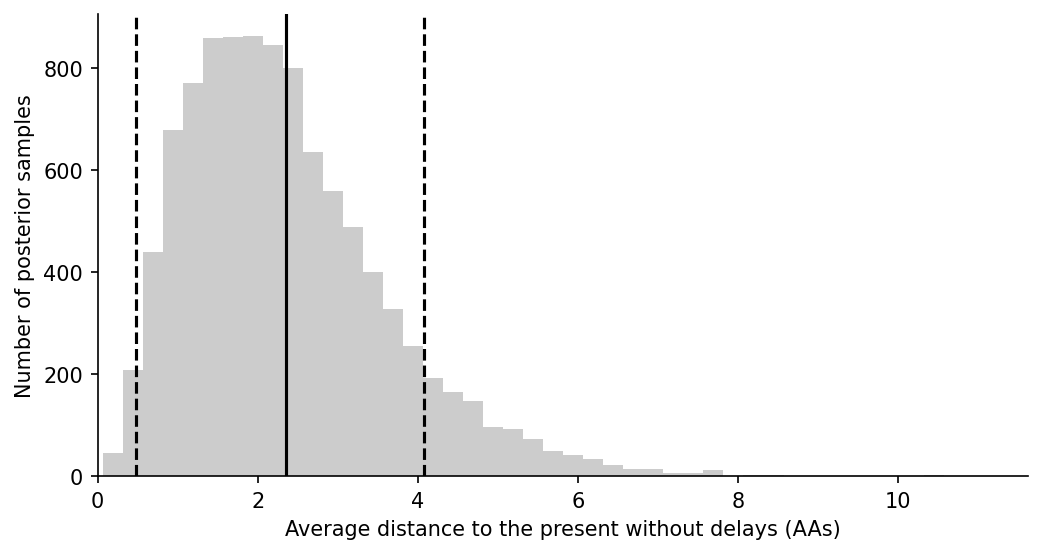

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)

ax.hist(
    average_distance_to_present,
    bins=bins,
    color="#CCCCCC",
)

ax.axvline(x=mean_average_distance_to_present, color="#000000")
ax.axvline(x=lower_hpdi_average_distance_to_present, color="#000000", linestyle="--")
ax.axvline(x=upper_hpdi_average_distance_to_present, color="#000000", linestyle="--")

ax.set_xlim(left=0)

ax.set_xlabel("Average distance to the present without delays (AAs)")
ax.set_ylabel("Number of posterior samples")

sns.despine()

## Plot effect of delays on distance to present

Create a sequence of average submission delays with standardization.

In [24]:
delay_seq = np.arange(0, 4)

In [25]:
delay_seq_s = (delay_seq - delay_mean) / delay_sd

In [26]:
delay_seq_s

array([-1.06767352, -0.26691838,  0.53383676,  1.3345919 ])

In [27]:
mu_mean_for_delays = []
mu_lower_hpdi = []
mu_upper_hpdi = []
distance_lower_hpdi = []
distance_upper_hpdi = []

for delay_s in delay_seq_s:
    mu = np.exp(posterior["a"] + posterior["b_s"] * delay_s + posterior["b_h"] * ((0 - horizon_mean) / horizon_sd))
    mu_mean_for_delays.append(mu.mean())
    
    mu_lower_hpdi_for_delay, mu_upper_hpdi_for_delay = az.hdi(mu.values, 0.89)
    mu_lower_hpdi.append(mu_lower_hpdi_for_delay)
    mu_upper_hpdi.append(mu_upper_hpdi_for_delay)
    
    scale = posterior["scale"]
    distance_for_delay = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)
    distance_lower_hpdi_for_delay, distance_upper_hpdi_for_delay = az.hdi(distance_for_delay, 0.89)
    distance_lower_hpdi.append(distance_lower_hpdi_for_delay)
    distance_upper_hpdi.append(distance_upper_hpdi_for_delay)

In [28]:
mu_mean_for_delays

[2.358846907279556, 2.421364587177661, 2.48610471189341, 2.5531562104418337]

In [29]:
mu_lower_hpdi

[2.1654509512923212, 2.22773095881777, 2.2820697151275167, 2.3251004981240944]

In [30]:
mu_upper_hpdi

[2.5675785723605844, 2.612235099316092, 2.6873364398664057, 2.7812557474378745]

In [31]:
distance_lower_hpdi

[0.5358988206835187,
 0.5108580615843552,
 0.5453640305492038,
 0.5962501542804416]

In [32]:
distance_upper_hpdi

[4.121942072293623, 4.1632503485797105, 4.249556081881888, 4.311421109338537]

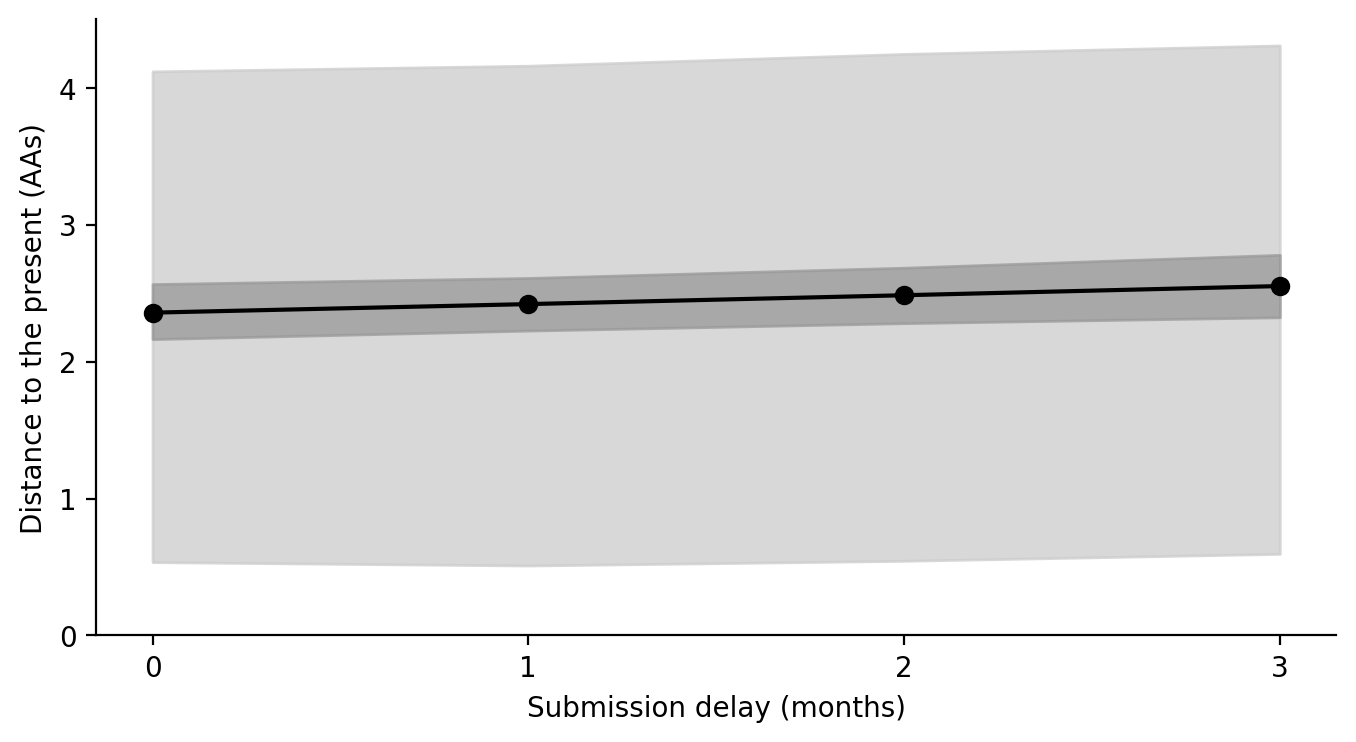

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

ax.plot(
    delay_seq,
    mu_mean_for_delays,
    "o-",
    color="#000000",
)

ax.fill_between(
    delay_seq,
    y1=mu_lower_hpdi,
    y2=mu_upper_hpdi,
    color="#999999",
    alpha=0.75,
    zorder=-10
)

ax.fill_between(
    delay_seq,
    y1=distance_lower_hpdi,
    y2=distance_upper_hpdi,
    color="#CCCCCC",
    alpha=0.75,
    zorder=-20
)

ax.set_xticks(delay_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Submission delay (months)")
ax.set_ylabel("Distance to the present (AAs)")

sns.despine()

## Plot effect of horizons and delays

In [34]:
horizon_seq = np.arange(3, 13, 3)

In [35]:
horizon_seq

array([ 3,  6,  9, 12])

In [36]:
delay_seq = np.array([0, 1, 3])

In [37]:
posterior_simulated_distances = []
records = []

for horizon in horizon_seq:
    horizon_s = (horizon - horizon_mean) / horizon_sd
    
    for delay in delay_seq:
        delay_s = (delay - delay_mean) / delay_sd
        
        mu = np.exp(posterior["a"] + posterior["b_s"] * delay_s + posterior["b_h"] * horizon_s)
        mu_mean = mu.mean()

        mu_lower_hpdi, mu_upper_hpdi = az.hdi(mu.values, 0.89)

        scale = posterior["scale"]
        distance = gamma.rvs(a=mu / scale, scale=scale, random_state=rng)
        distance_lower_hpdi, distance_upper_hpdi = az.hdi(distance, 0.89)
        
        posterior_simulated_distances.append(
            pd.DataFrame({
                "horizon": horizon,
                "delay": delay,
                "distance": distance,
            })
        )

        records.append({
            "horizon": horizon,
            "delay": delay,
            "mu_mean": mu_mean,
            "mu_lower_hpdi": mu_lower_hpdi,
            "mu_upper_hpdi": mu_upper_hpdi,
            "distance_lower_hpdi": distance_lower_hpdi,
            "distance_upper_hpdi": distance_upper_hpdi,
        })

In [38]:
df = pd.DataFrame(records)

In [39]:
df.head()

,horizon,delay,mu_mean,mu_lower_hpdi,mu_upper_hpdi,distance_lower_hpdi,distance_upper_hpdi
0,3,0,2.927251,2.741998,3.113586,0.799781,4.877719
1,3,1,3.004816,2.839925,3.175661,0.890305,5.052845
2,3,3,3.168326,2.956251,3.392483,0.915075,5.160641
3,6,0,3.633700,3.457441,3.810302,1.362457,5.954149
4,6,1,3.729961,3.588182,3.866574,1.397183,6.015360


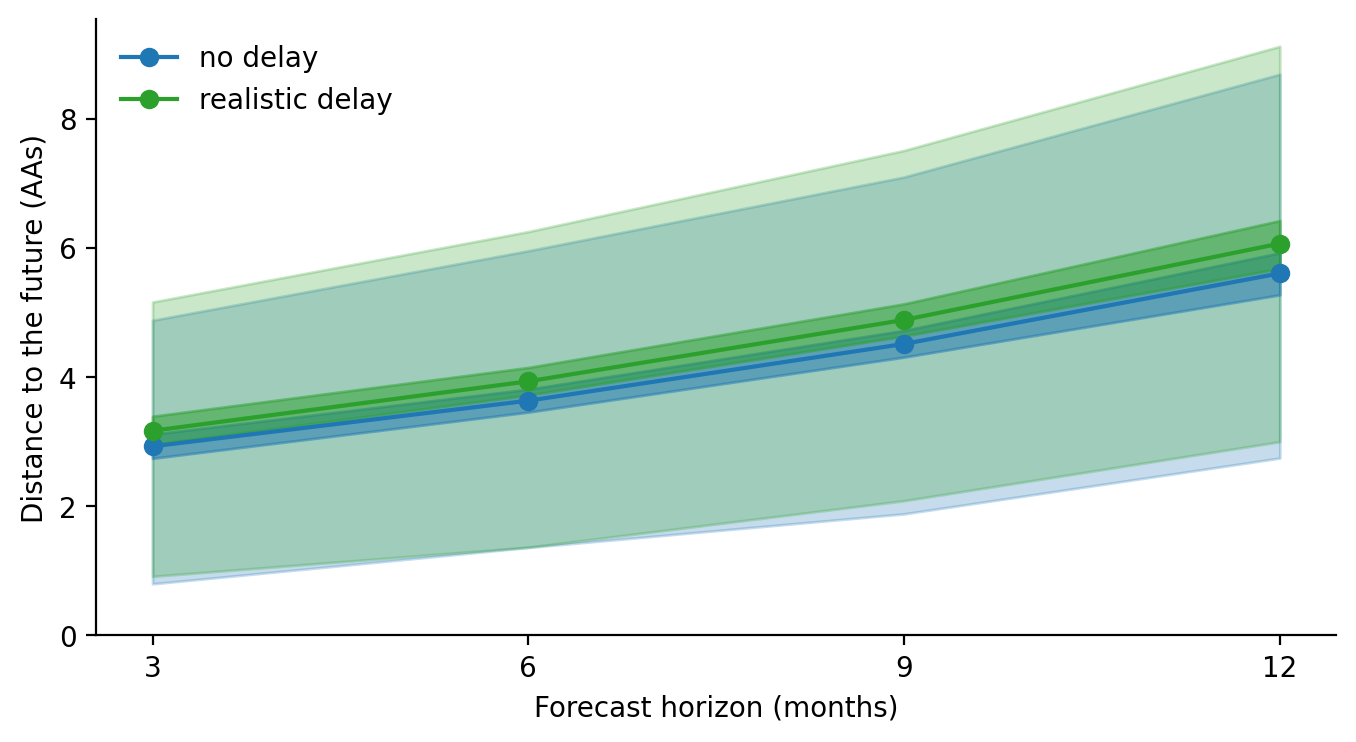

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

# Distance to the future without delay
ax.plot(
    df.query("delay == 0")["horizon"],
    df.query("delay == 0")["mu_mean"],
    "o-",
    color="C0",
    label="no delay",
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["mu_lower_hpdi"],
    y2=df.query("delay == 0")["mu_upper_hpdi"],
    color="C0",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["distance_lower_hpdi"],
    y2=df.query("delay == 0")["distance_upper_hpdi"],
    color="C0",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 3")["horizon"],
    df.query("delay == 3")["mu_mean"],
    "o-",
    color="C2",
    label="realistic delay",
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["mu_lower_hpdi"],
    y2=df.query("delay == 3")["mu_upper_hpdi"],
    color="C2",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["distance_lower_hpdi"],
    y2=df.query("delay == 3")["distance_upper_hpdi"],
    color="C2",
    alpha=0.25,
    zorder=-20
)

ax.set_xticks(horizon_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Forecast horizon (months)")
ax.set_ylabel("Distance to the future (AAs)")

ax.legend(
    loc="upper left",
    frameon=False,
)

sns.despine()

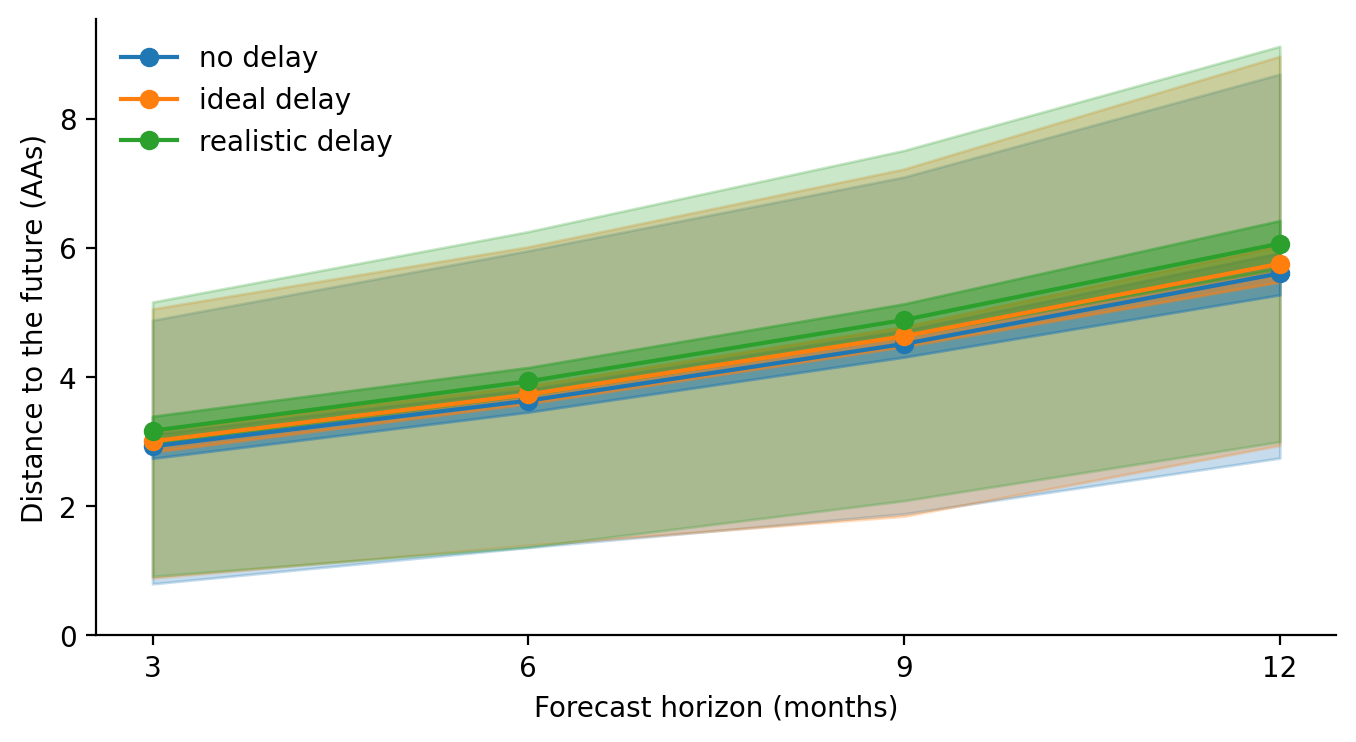

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

# Distance to the future without delay
ax.plot(
    df.query("delay == 0")["horizon"],
    df.query("delay == 0")["mu_mean"],
    "o-",
    color="C0",
    label="no delay",
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["mu_lower_hpdi"],
    y2=df.query("delay == 0")["mu_upper_hpdi"],
    color="C0",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 0")["horizon"],
    y1=df.query("delay == 0")["distance_lower_hpdi"],
    y2=df.query("delay == 0")["distance_upper_hpdi"],
    color="C0",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 1")["horizon"],
    df.query("delay == 1")["mu_mean"],
    "o-",
    color="C1",
    label="ideal delay",
)

ax.fill_between(
    df.query("delay == 1")["horizon"],
    y1=df.query("delay == 1")["mu_lower_hpdi"],
    y2=df.query("delay == 1")["mu_upper_hpdi"],
    color="C1",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 1")["horizon"],
    y1=df.query("delay == 1")["distance_lower_hpdi"],
    y2=df.query("delay == 1")["distance_upper_hpdi"],
    color="C1",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    df.query("delay == 3")["horizon"],
    df.query("delay == 3")["mu_mean"],
    "o-",
    color="C2",
    label="realistic delay",
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["mu_lower_hpdi"],
    y2=df.query("delay == 3")["mu_upper_hpdi"],
    color="C2",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    df.query("delay == 3")["horizon"],
    y1=df.query("delay == 3")["distance_lower_hpdi"],
    y2=df.query("delay == 3")["distance_upper_hpdi"],
    color="C2",
    alpha=0.25,
    zorder=-20
)

ax.set_xticks(horizon_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Forecast horizon (months)")
ax.set_ylabel("Distance to the future (AAs)")

ax.legend(
    loc="upper left",
    frameon=False,
)

sns.despine()

## Plot improvements under different realistic scenarios

We consider three possible realistic scenarios for future practice of influenza genomic surveillance and vaccine development:

1. A change in vaccine development reduces the required forecast horizon from 12 months to 6 months (e.g., through adoption of mRNA-based vaccines).
2. A change in genomic surveillance capacity and policy reduces the average submission delay of genomes to GISAID from 3 months to 1 month.
3. Both changes to vaccine development and genomic surveillance occur at once.

In [42]:
posterior_simulated_distance_df = pd.concat(posterior_simulated_distances)

In [43]:
posterior_simulated_distance_df.head()

,horizon,delay,distance
0,3,0,7.243163
1,3,0,2.271006
2,3,0,2.161736
3,3,0,1.996515
4,3,0,5.820007


Get difference in distances for scenario 1 where delay=3 and horizon=12 or 6.

In [44]:
scenario_1_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 6)")["distance"]
)

In [45]:
scenario_1_improvement.mean()

2.110550294143071

Get difference in distances for scenario 2 where horizon=12 and delay=3 or 1.

In [46]:
scenario_2_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 1) & (horizon == 12)")["distance"]
)

In [47]:
scenario_2_improvement.mean()

0.2787785703686486

Finally, get difference in distances for scenario 3 where horizon/delay is either 12/3 or 6/1.

In [48]:
scenario_3_improvement = (
    posterior_simulated_distance_df.query("(delay == 3) & (horizon == 12)")["distance"] - 
    posterior_simulated_distance_df.query("(delay == 1) & (horizon == 6)")["distance"]
)

In [49]:
scenario_3_improvement.mean()

2.332866999146365

In [50]:
bins = np.arange(
    min(scenario_1_improvement.min(), scenario_2_improvement.min(), scenario_3_improvement.min()),
    max(scenario_1_improvement.max(), scenario_2_improvement.max(), scenario_3_improvement.max()) + 0.1,
    0.25,
)

In [51]:
bins

array([-12.79904533, -12.54904533, -12.29904533, -12.04904533,
       -11.79904533, -11.54904533, -11.29904533, -11.04904533,
       -10.79904533, -10.54904533, -10.29904533, -10.04904533,
        -9.79904533,  -9.54904533,  -9.29904533,  -9.04904533,
        -8.79904533,  -8.54904533,  -8.29904533,  -8.04904533,
        -7.79904533,  -7.54904533,  -7.29904533,  -7.04904533,
        -6.79904533,  -6.54904533,  -6.29904533,  -6.04904533,
        -5.79904533,  -5.54904533,  -5.29904533,  -5.04904533,
        -4.79904533,  -4.54904533,  -4.29904533,  -4.04904533,
        -3.79904533,  -3.54904533,  -3.29904533,  -3.04904533,
        -2.79904533,  -2.54904533,  -2.29904533,  -2.04904533,
        -1.79904533,  -1.54904533,  -1.29904533,  -1.04904533,
        -0.79904533,  -0.54904533,  -0.29904533,  -0.04904533,
         0.20095467,   0.45095467,   0.70095467,   0.95095467,
         1.20095467,   1.45095467,   1.70095467,   1.95095467,
         2.20095467,   2.45095467,   2.70095467,   2.95

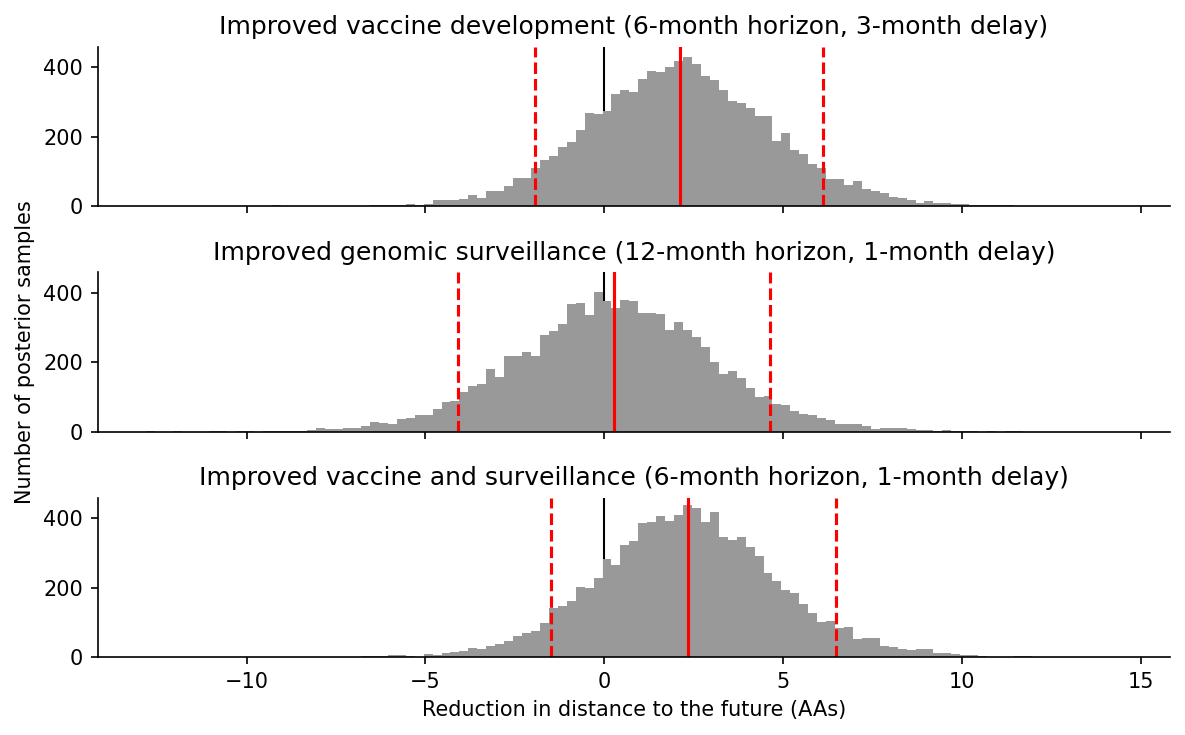

In [52]:
fig, axes = plt.subplots(3, 1, figsize=(8, 5), dpi=150, sharex=True, sharey=True)
all_axes = axes.flatten()

# Scenario 1
ax1 = all_axes[0]
ax1.hist(
    scenario_1_improvement,
    bins=bins,
    color="#999999",
)
ax1.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax1.axvline(x=scenario_1_improvement.mean(), color="red")
ax1.axvline(x=az.hdi(scenario_1_improvement.values, 0.89)[0], color="red", linestyle="--")
ax1.axvline(x=az.hdi(scenario_1_improvement.values, 0.89)[1], color="red", linestyle="--")

ax1.set_title("Improved vaccine development (6-month horizon, 3-month delay)")

# Scenario 2
ax2 = all_axes[1]
ax2.hist(
    scenario_2_improvement,
    bins=bins,
    color="#999999",
)
ax2.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax2.axvline(x=scenario_2_improvement.mean(), color="red")
ax2.axvline(x=az.hdi(scenario_2_improvement.values, 0.89)[0], color="red", linestyle="--")
ax2.axvline(x=az.hdi(scenario_2_improvement.values, 0.89)[1], color="red", linestyle="--")

ax2.set_ylabel("Number of posterior samples")
ax2.set_title("Improved genomic surveillance (12-month horizon, 1-month delay)")

# Scenario 3
ax3 = all_axes[2]
ax3.hist(
    scenario_3_improvement,
    bins=bins,
    color="#999999",
)
ax3.axvline(x=0, color="#000000", zorder=-10, linewidth=1)
ax3.axvline(x=scenario_3_improvement.mean(), color="red")
ax3.axvline(x=az.hdi(scenario_3_improvement.values, 0.89)[0], color="red", linestyle="--")
ax3.axvline(x=az.hdi(scenario_3_improvement.values, 0.89)[1], color="red", linestyle="--")

ax3.set_xlabel("Reduction in distance to the future (AAs)")
ax3.set_title("Improved vaccine and surveillance (6-month horizon, 1-month delay)")

sns.despine()
plt.tight_layout()